# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import torchinfo
from torch.utils.tensorboard import SummaryWriter
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gc
import concurrent.futures
import optuna, optunahub
from optuna.visualization import plot_slice, plot_param_importances
import json
import copy
import random
from sklearn.cluster import DBSCAN

gc.enable()

In [2]:
torch._dynamo.config.cache_size_limit = 64
torch.backends.cudnn.benchmark = True

In [3]:
notebook_number = '20250202_05'

In [4]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [5]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [6]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [7]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x7cbba653fb00

In [8]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            if tomo_type != 'denoised':
                continue
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [9]:
train_label_experiment_folders_path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/' + 'train/overlay/ExperimentRuns/'

In [10]:
class_ids = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [11]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [12]:
def create_labels_df(experiment):
    labels_dict = {}
    
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json
    
    labels_dict[experiment] = particle_types_dict

    experiment_list = []
    particle_type_list = []
    x_list = []
    y_list = []
    z_list = []
    r_list = []
    class_id_list = []
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

    labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'radius':r_list, 'label':class_id_list})
    
    return labels_df

In [13]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    labels_df = create_labels_df(run.name)
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        if tomo_type != 'denoised':
            continue
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation, "label_df": labels_df})
    
print(np.unique(data_dicts[0]['label']))

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


[0 1 2 3 4 5]


In [14]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [15]:
data_dicts[0]['label'].shape

(184, 630, 630)

In [16]:
len(data_dicts)

7

In [17]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [18]:
data_dicts[0]['label_df']

,experiment,particle_type,x,y,z,radius,label
0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,6.0,1
1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,6.0,1
2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,6.0,1
3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,6.0,1
4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,6.0,1
...,...,...,...,...,...,...,...
125,TS_5_4,virus-like-particle,263.326203,420.974132,96.421012,13.5,5
126,TS_5_4,virus-like-particle,313.349651,356.801989,37.245052,13.5,5
127,TS_5_4,virus-like-particle,329.003870,302.370125,67.323222,13.5,5
128,TS_5_4,virus-like-particle,299.396016,494.206799,116.792162,13.5,5


## 4. Visualize the tomogram and painted segmentation from ground-truth picks

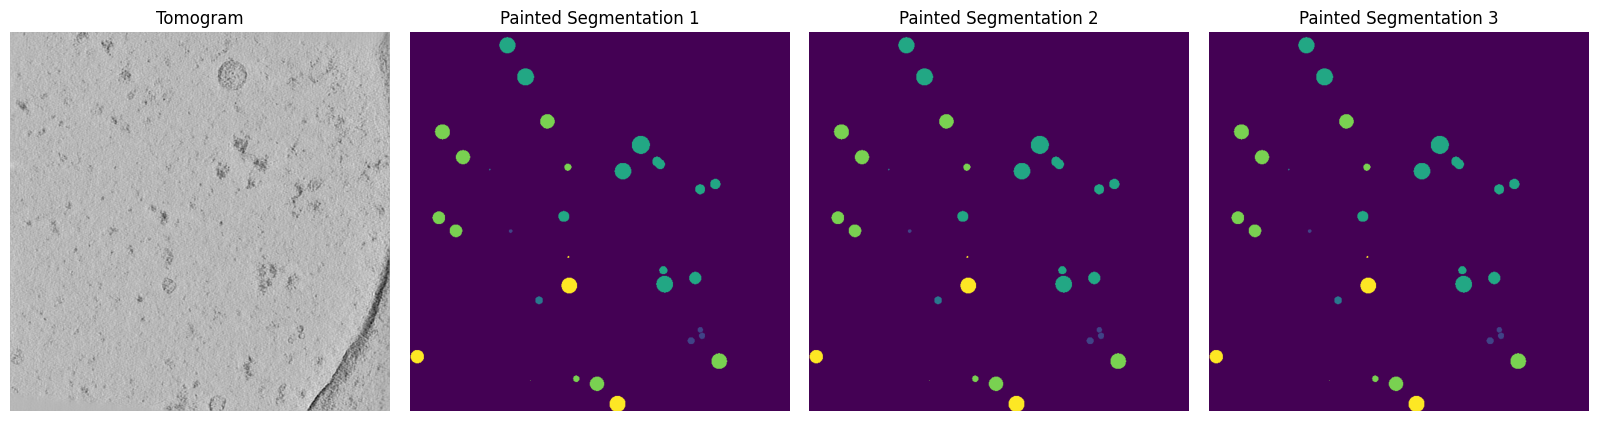

In [19]:
# Create figure
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Adjust figsize to control spacing

# Image 1
axes[0].imshow(data_dicts[0]['image'][100], cmap='gray')
axes[0].set_title('Tomogram')
axes[0].axis('off')

# Image 2
axes[1].imshow(data_dicts[0]['label'][100], cmap='viridis')
axes[1].set_title('Painted Segmentation 1')
axes[1].axis('off')

# Image 3
axes[2].imshow(data_dicts[0]['label'][100], cmap='viridis')
axes[2].set_title('Painted Segmentation 2')
axes[2].axis('off')

# Image 4
axes[3].imshow(data_dicts[0]['label'][100], cmap='viridis')
axes[3].set_title('Painted Segmentation 3')
axes[3].axis('off')

# Reduce spacing
plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding

plt.show()

# Simulated data prep

In [20]:
simulated_data_path = '../../czii_downloaded_data/simulated_training_data/'

In [21]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

['TS_26',
 'TS_13',
 'TS_22',
 'TS_17',
 'TS_1',
 'TS_24',
 'TS_19',
 'TS_4',
 'TS_6',
 'TS_23',
 'TS_2',
 'TS_16',
 'TS_14',
 'TS_20',
 'TS_18',
 'TS_0',
 'TS_21',
 'TS_3',
 'TS_9',
 'TS_7',
 'TS_10',
 'TS_11',
 'TS_25',
 'TS_12',
 'TS_15',
 'TS_5',
 'TS_8']

In [22]:
particle_info = {
    "apo-ferritin": {"label": 1, "radius": 60},
    "beta-galactosidase": {"label": 2, "radius": 90},
    "ribosome": {"label": 3, "radius": 150},
    "thyroglobulin": {"label": 4, "radius": 130},
    "virus-like-particle": {"label": 5, "radius": 135}
}

In [23]:
# Define enzyme radii
particle_radius = {
    'apo-ferritin': 60 / 10,
    'beta-galactosidase': 90 / 10,
    'ribosome': 150 / 10,
    'thyroglobulin': 130 / 10,
    'virus-like-particle': 135 / 10,
}

# Map enzyme names to numerical class labels (for segmentation)
enzyme_class_mapping = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [24]:
def create_masks(image_shape, locations_df):
    """
    Creates a two-channel segmentation mask:
    - Channel 1: Enzyme class labels (1-5).
    - Channel 2: Enzyme radius at each voxel.
    
    Returns:
    - volume: np.ndarray with shape (2, z, y, x).
    """
    segmentation_mask = np.zeros(image_shape, dtype=np.uint8)  # Enzyme class labels (1-5)
    radius_mask = np.zeros(image_shape, dtype=np.float32)  # Stores enzyme radius values

    centers = locations_df[['z', 'y', 'x']].values
    enzyme_names = locations_df['particle_type'].values  # Now we use enzyme names!

    for center, enzyme_name in zip(centers, enzyme_names):
        if enzyme_name not in particle_radius:
            continue  # Skip unknown enzymes

        radius = particle_radius[enzyme_name]  # Get fixed radius for enzyme
        class_label = enzyme_class_mapping[enzyme_name]  # Get class label

        # Compute bounding box
        z_min, z_max = max(0, int(center[0] - radius)), min(image_shape[0], int(center[0] + radius) + 1)
        y_min, y_max = max(0, int(center[1] - radius)), min(image_shape[1], int(center[1] + radius) + 1)
        x_min, x_max = max(0, int(center[2] - radius)), min(image_shape[2], int(center[2] + radius) + 1)

        # Create local grid
        zz, yy, xx = np.meshgrid(
            np.arange(z_min, z_max),
            np.arange(y_min, y_max),
            np.arange(x_min, x_max),
            indexing='ij'
        )

        # Compute distance from center
        dist_map = np.sqrt((xx - center[2])**2 + (yy - center[1])**2 + (zz - center[0])**2)

        # Apply mask only where within the radius
        mask = dist_map <= radius
        segmentation_mask[z_min:z_max, y_min:y_max, x_min:x_max][mask] = class_label  # Assign enzyme class
        radius_mask[z_min:z_max, y_min:y_max, x_min:x_max][mask] = radius  # Store radius info

    return np.stack([segmentation_mask, radius_mask], axis=0)  # Shape: (2, z, y, x)

In [26]:

for i in tqdm(range(len(data_dicts))):
    data_dicts[i]['label'] = create_masks(data_dicts[i]['image'].shape, data_dicts[i]['label_df'])


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.70it/s]


In [27]:
particle_name_dict = {
    'ferritin':'apo-ferritin',
    'galacto':'beta-galactosidase',
    'ribosome':'ribosome',
    'thyro':'thyroglobulin',
    'vlp':'virus-like-particle'
}

In [28]:
def process_experiment(experiment):
    """Process a single experiment in parallel"""
    # Load tomogram data
    tomogram_path = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Tomograms/100/{experiment}.zarr'
    tomogram = zarr.open(tomogram_path, mode='r')[0].__array__()
    
    location_dfs_list = []
    annotations_base = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/'
    
    # Process location files
    for location_folder in os.listdir(annotations_base):
        location_dir = os.path.join(annotations_base, location_folder)
        for location_file in os.listdir(location_dir):
            if 'orientedpoint.ndjson' not in location_file:
                continue
                
            # Determine particle type
            particle_type = None
            for key in particle_name_dict.keys():
                if key in location_file:
                    particle_type = particle_name_dict[key]
                    break
            if not particle_type:
                continue
                
            # Process NDJSON file
            label = particle_info[particle_type]['label']
            radius = particle_info[particle_type]['radius']
            file_path = os.path.join(location_dir, location_file)
            
            location_df = pd.read_json(file_path, lines=True)
            location_df['x'] = location_df['location'].map(lambda x: x['x'])
            location_df['y'] = location_df['location'].map(lambda x: x['y'])
            location_df['z'] = location_df['location'].map(lambda x: x['z'])
            location_df['label'] = label
            location_df['radius'] = radius / 10.012444
            location_df['particle_type'] = particle_type
            
            location_dfs_list.append(location_df)
    
    # Create mask and return result
    if location_dfs_list:
        all_particle_locations_df = pd.concat(location_dfs_list, ignore_index=True)
        mask_image = create_masks_with_radius(tomogram.shape, all_particle_locations_df)
        all_particle_locations_df['experiment'] = experiment
        label_df = all_particle_locations_df[['experiment', 'particle_type', 'x', 'y', 'z', 'radius', 'label']]
        return {"tomo_type": 'Unknown', "image": tomogram, "label": mask_image, "label_df": label_df}
    return None

def append_simulation_data():
    global data_dicts
    max_workers = os.cpu_count() // 2  # Use half the available cores to prevent memory issues
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all experiments for processing
        futures = [executor.submit(process_experiment, exp) for exp in simulated_experiments_list]
        
        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), 
                         total=len(simulated_experiments_list),
                         desc="Processing experiments"):
            result = future.result()
            if result:
                data_dicts.append(result)

In [29]:
#append_simulation_data()

In [30]:
len(data_dicts)

7

In [31]:
data_dicts[-1]['label_df']

,experiment,particle_type,x,y,z,radius,label
0,TS_99_9,apo-ferritin,606.491649,403.298128,71.478950,6.0,1
1,TS_99_9,apo-ferritin,596.003501,422.295787,112.320326,6.0,1
2,TS_99_9,apo-ferritin,584.035395,506.041272,67.804922,6.0,1
3,TS_99_9,apo-ferritin,47.226529,562.561737,57.995429,6.0,1
4,TS_99_9,apo-ferritin,56.380537,559.791385,67.731713,6.0,1
...,...,...,...,...,...,...,...
182,TS_99_9,virus-like-particle,200.755769,474.671110,105.576419,13.5,5
183,TS_99_9,virus-like-particle,224.127883,430.470614,95.835540,13.5,5
184,TS_99_9,virus-like-particle,80.327037,580.990504,57.877276,13.5,5
185,TS_99_9,virus-like-particle,419.300999,552.769922,85.710240,13.5,5


In [32]:
'''
for i in range(len(data_dicts)):
    img = data_dicts[i]['image']
    img = img - np.min(img)
    img = img / np.max(img)
    data_dicts[i]['image'] = img
'''

"\nfor i in range(len(data_dicts)):\n    img = data_dicts[i]['image']\n    img = img - np.min(img)\n    img = img / np.max(img)\n    data_dicts[i]['image'] = img\n"

# 5. Prepare dataloaders

In [33]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
    RandGaussianNoised,
    RandAdjustContrastd,
    MapTransform,
    RandZoomd,
    RandRotate90d
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss, GeneralizedDiceFocalLoss, DiceFocalLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import torchio as tio
from scipy.ndimage import sobel
from monai.networks.utils import one_hot

In [34]:
exp_names_list = []
for i in range(len(data_dicts)):
    exp_name = data_dicts[i]['label_df']['experiment'][0]
    exp_names_list.append(exp_name)
exp_names_sr = pd.Series(exp_names_list)
unique_exp_names = exp_names_sr.unique()
unique_exp_names

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9'], dtype=object)

In [35]:
len(unique_exp_names)

7

In [36]:
data_dicts_copy = copy.deepcopy(data_dicts)
len(data_dicts_copy)

7

In [37]:
num_classes = 6 # 1 background + 5 particles
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1
loader_workers = 8
cube_size = 160

In [38]:
# Define TorchIO transforms (applies to both image & label)
torchio_transforms = tio.Compose([
    #tio.RandomElasticDeformation(num_control_points=7, max_displacement=3, image_interpolation='linear', locked_borders=2, p=0.5),  # Elastic deformation
    tio.RandomNoise(std=0.1, include=["image"], p=0.2),  # Noise ONLY on the image
    #tio.RandomGhosting(num_ghosts=2, axes=(0, 1), include=["image"], p=0.5),  # Ghosting ONLY on the image
    tio.RandomBiasField(include=['image'], p=0.2, coefficients=0.3, order=2),
    tio.RandomGamma(include=['image'], p=0.5)
])

In [39]:
class TorchIOTransform(MapTransform):
    """
    Applies TorchIO augmentations to both image and label.
    Ensures that both undergo the same transformations for segmentation tasks.
    """
    def __init__(self, keys, torchio_transform):
        super().__init__(keys)
        self.torchio_transform = torchio_transform

    def __call__(self, data):
        # Ensure the image tensor is 4D (C, H, W, D)
        image = data["image"]
        label = data["label"]

        if image.ndim == 5:  # (B, C, H, W, D) -> Remove batch dimension
            image = image.squeeze(0)
            label = label.squeeze(0)

        # Wrap image & label as a TorchIO Subject (keeps transformations consistent)
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),  # Ensure 4D (C, H, W, D)
            label=tio.LabelMap(tensor=label)  # Ensure 4D (C, H, W, D)
        )

        # Apply TorchIO transformations
        transformed = self.torchio_transform(subject)

        # Convert back to MONAI format
        data["image"] = transformed.image.data  # Keep it 4D
        data["label"] = transformed.label.data  # Keep it 4D
        return data

In [62]:
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),  # Ensure image is (C, Z, Y, X)
    EnsureChannelFirstd(keys=["label"], channel_dim="no_channel"),  # Ensure label is (2, Z, Y, X)
    
    NormalizeIntensityd(keys="image"),  # Normalize image only

    # Apply Orientationd **only to the image** (not label)
    Orientationd(keys=["image"], axcodes="RAS"),  
])

In [40]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  # Random contrast change
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    #RandZoomd(keys=['image', 'label'], prob=1),
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),  # Apply TorchIO
])

In [41]:
# Validation transforms
val_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
        allow_missing_keys=True
    ),
])

## Model setup

In [42]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Loss functions

In [44]:
class_weights = torch.tensor([
    0.0,  # Background (weight=0)
    1.0,  # apo-ferritin
    2.0,  # beta-galactosidase (higher weight)
    1.0,  # ribosome
    2.0,  # thyroglobulin (higher weight)
    1.0   # virus-like-particle
], device='cuda')

In [45]:
#dice_loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
tversky_loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [46]:
post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
post_label = AsDiscrete(to_onehot=num_classes)

In [47]:
id_to_name = {1: "apo-ferritin", 
              #2: "beta-amylase",
              2: "beta-galactosidase", 
              3: "ribosome", 
              4: "thyroglobulin", 
              5: "virus-like-particle"}

In [48]:
classes = [1, 2, 3, 4, 5]

In [49]:
from typing import List, Tuple, Union
import cc3d

In [50]:
def extract_3d_patches_minimal_overlap(
    arrays: List[np.ndarray], patch_size: int, overlap: int = 48
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than the smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension with fixed overlap
    x_starts = calculate_patch_starts(m, patch_size, overlap)
    y_starts = calculate_patch_starts(n, patch_size, overlap)
    z_starts = calculate_patch_starts(l, patch_size, overlap)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

In [51]:
def reconstruct_prediction_array(
    patches: List[np.ndarray], 
    coordinates: List[Tuple[int, int, int]], 
    original_shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Reconstructs the full probability tensor by averaging overlapping patch contributions.
    
    Args:
    - patches: List of predicted probability patches, each with shape (6, 96, 96, 96).
    - coordinates: List of (x, y, z) positions for each patch.
    - original_shape: Tuple (C, D, H, W) for the final tensor shape.
    
    Returns:
    - A tensor of shape (6, 184, 630, 630) with averaged probabilities.
    """
    num_classes = patches[0].shape[0]  # Should be 6

    original_shape = tuple([num_classes] + list(original_shape))
    
    reconstructed = np.zeros(original_shape, dtype=np.float32)  # Stores summed probabilities
    count = np.zeros(original_shape, dtype=np.float32)  # Stores the number of contributions

    patch_size = patches[0].shape[1]  # Should be 96

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            :,
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += patch  # Sum up probabilities
        count[
            :,
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += 1  # Track contributions

    # Normalize to get the averaged probabilities
    count[count == 0] = 1  # Avoid division by zero
    
    return torch.tensor((reconstructed / count).astype(np.float32))  # Compute the average probability per voxel


def calculate_patch_starts(dimension_size: int, patch_size: int, overlap: int) -> List[int]:
    """
    Calculates the starting indices for patch extraction, ensuring a fixed overlap.
    """
    step = patch_size - overlap
    positions = list(range(0, dimension_size - patch_size + 1, step))

    # Ensure the last patch reaches the end
    if positions[-1] + patch_size < dimension_size:
        positions.append(dimension_size - patch_size)

    return positions

In [52]:
def dict_to_df(coord_dict, experiment_name):
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    return df

In [53]:
def ensemble_prediction_tta(model, input_tensor):
    probs_list = []
    
    data_copy0 = input_tensor.clone()
    data_copy0 = torch.flip(data_copy0, dims=[2])
    data_copy1 = input_tensor.clone()
    data_copy1 = torch.flip(data_copy1, dims=[3])
    data_copy2 = input_tensor.clone()
    data_copy2 = torch.flip(data_copy2, dims=[4])
    data_copy3 = input_tensor.clone()
    data_copy3 = data_copy3.rot90(1, dims=[3, 4])
    
    model_output0 = model(input_tensor)
    model_output1 = model(data_copy0)
    model_output1 = torch.flip(model_output1, dims=[2])
    model_output2 = model(data_copy1)
    model_output2 = torch.flip(model_output2, dims=[3])
    model_output3 = model(data_copy2)
    model_output3 = torch.flip(model_output3, dims=[4])
    
    probs0 = torch.softmax(model_output0[0], dim=0)
    probs1 = torch.softmax(model_output1[0], dim=0)
    probs2 = torch.softmax(model_output2[0], dim=0)
    probs3 = torch.softmax(model_output3[0], dim=0)
    
    probs_list.append(probs0)
    probs_list.append(probs1)
    probs_list.append(probs2)
    probs_list.append(probs3)
    
    avg_probs = torch.mean(torch.stack(probs_list), dim=0)

    return avg_probs

In [55]:
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [56]:
inference_transforms_dict = {
    'gpt': gpt_inference_transforms,
    'original': inference_transforms
}

In [57]:
learning_rate = 0.0009
num_res_units = 3
prediction_threshold = 0.05
#validation_experiment = 'TS_86_3'
dropout = 0.3
first_channel_size = 48

In [58]:
data_dicts = copy.deepcopy(data_dicts_copy)

In [59]:
train_files = data_dicts[1:]
val_files = [data_dicts[0]]

train_files_copy = copy.deepcopy(train_files)
val_files_copy = copy.deepcopy(val_files)

print(len(train_files))
print(len(val_files))

6
1


In [60]:
for iiii in range(len(train_files)):
    del train_files[iiii]['tomo_type'], train_files[iiii]['label_df']

for iiiii in range(len(val_files)):
    del val_files[iiiii]['tomo_type'], val_files[iiiii]['label_df']


In [64]:
from monai.transforms import Lambdad

random_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[0]),  

    # Apply RandCropByLabelClassesd on 3D segmentation mask
    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label by stacking back the cropped segmentation and radius map
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),

    # Apply other augmentations
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [65]:
val_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[0]),

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),
])


In [67]:
from monai.transforms import Lambdad

random_transforms = Compose([
    # Extract only the first channel (segmentation mask) before rotation
    Lambdad(keys=["label"], func=lambda x: x[0]),  

    # Apply rotation **only on the segmentation mask**
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),

    # Restore multi-channel label (stack back rotated segmentation + unchanged radius map)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [68]:
val_transforms = Compose([
    Lambdad(keys=["label"], func=lambda x: x[0]),  # Extract only segmentation mask

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),
])


In [70]:
from monai.transforms import Lambdad

random_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[0]),  

    # Apply cropping only on enzyme segmentation (3D mask)
    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + cropped radius map)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),

    # Apply other augmentations
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [71]:
val_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[0]),

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),
])


In [73]:
from monai.transforms import Lambdad

random_transforms = Compose([
    # Extract only the first channel (segmentation mask) before rotation
    Lambdad(keys=["label"], func=lambda x: x[0:1]),  # Keeps the dimension as (1, z, y, x) instead of (z, y, x)

    # Apply rotation **only on the segmentation mask**
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),

    # Restore multi-channel label (stack back rotated segmentation + unchanged radius map)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x, np.zeros_like(x)], axis=0)),  # Restore (2, z, y, x)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [74]:
val_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[0:1]),

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x, np.zeros_like(x)], axis=0)),  # Restore (2, z, y, x)
])


In [76]:
from monai.transforms import Lambdad

random_transforms = Compose([
    # Extract only the first channel (segmentation mask) before rotation
    Lambdad(keys=["label"], func=lambda x: x[:1]),  # Keeps (1, z, y, x)

    # Apply rotation **only on the segmentation mask**
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),

    # Restore multi-channel label (stack back rotated segmentation + unchanged radius map)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x, np.zeros_like(x)], axis=0)),  # Restore (2, z, y, x)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [77]:
val_transforms = Compose([
    # Extract only the first channel (segmentation mask) before cropping
    Lambdad(keys=["label"], func=lambda x: x[:1]),

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    # Restore multi-channel label (stack back cropped segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x, np.zeros_like(x)], axis=0)),  # Restore (2, z, y, x)
])


In [79]:
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),  # Ensure image is (C, Z, Y, X)
    EnsureChannelFirstd(keys=["label"], channel_dim="no_channel"),  # Ensure label is (C, Z, Y, X)

    NormalizeIntensityd(keys="image"),  # Normalize image only

    # Extract only the segmentation mask before caching (Store as 3D)
    Lambdad(keys=["label"], func=lambda x: x[0]),  # Keep only (Z, Y, X)

    Orientationd(keys=["image"], axcodes="RAS"),  # Apply orientation only to image
])


In [80]:
random_transforms = Compose([
    # Restore multi-channel label (segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),  # Converts back to (2, Z, Y, X)

    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),  # Now works on (2, Z, Y, X)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [81]:
val_transforms = Compose([
    # Restore multi-channel label (segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),  

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
])


In [83]:
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),  # Ensure image is (C, Z, Y, X)
    EnsureChannelFirstd(keys=["label"], channel_dim="no_channel"),  # Ensure label is (C, Z, Y, X)

    NormalizeIntensityd(keys="image"),  # Normalize image only

    # Store only the first channel (segmentation mask) before caching
    Lambdad(keys=["label"], func=lambda x: x[0]),  # This makes label (Z, Y, X)

    Orientationd(keys=["image"], axcodes="RAS"),  # Apply orientation only to image
])


In [84]:
random_transforms = Compose([
    # Convert cached 3D segmentation mask back to 4D (segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),  # Now (2, Z, Y, X)

    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),  # Now works on (2, Z, Y, X)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [85]:
val_transforms = Compose([
    # Convert cached 3D segmentation mask back to 4D (segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: np.stack([x, np.zeros_like(x)], axis=0)),  

    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
])


In [87]:
from monai.transforms import Compose, Lambdad, RandRotate90d

random_transforms = Compose([
    # Split the two channels (segmentation + radius)
    Lambdad(keys=["label"], func=lambda x: (x[0], x[1])),

    # Rotate segmentation **ONLY**
    Lambdad(keys=["label"], func=lambda x: (RandRotate90d(keys=["image"], prob=0.5, spatial_axes=[0, 2])(x[0]), x[1])),

    # Stack them back together
    Lambdad(keys=["label"], func=lambda x: np.stack([x[0], x[1]], axis=0)),

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [89]:
from monai.transforms import Compose, RandRotate90d, Lambdad

random_transforms = Compose([
    # Extract only the segmentation mask (first channel)
    Lambdad(keys=["label"], func=lambda x: x[0:1]),  # Keeps (1, Z, Y, X)

    # Rotate only the segmentation mask
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),  

    # Restore multi-channel label (stack rotated segmentation + unchanged radius)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x, np.zeros_like(x)], axis=0)),  # Restore (2, Z, Y, X)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [93]:
from monai.transforms import Compose, RandRotate90d, Lambdad

random_transforms = Compose([
    # Extract segmentation mask (first channel) & keep radius (second channel)
    Lambdad(keys=["label"], func=lambda x: (x[0:1], x[1:2])),

    # Rotate only the segmentation mask (first channel)
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),  

    # Restore multi-channel label (stack rotated segmentation + unchanged radius)
    Lambdad(keys=["label"], func=lambda x: np.concatenate([x[0], x[1]], axis=0)),  # Restore (2, Z, Y, X)

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [95]:
from monai.transforms import Compose, RandRotate90d, Lambdad, EnsureTyped

random_transforms = Compose([
    # Ensure the label is a tensor (fixes the 'tuple' issue)
    EnsureTyped(keys=["label"]),

    # Extract segmentation mask (first channel) & keep radius (second channel)
    Lambdad(keys=["label"], func=lambda x: (x[0:1], x[1:2])),

    # Rotate only the segmentation mask
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes=[0, 2]),  
    RandRotate90d(keys=["label"], prob=0.5, spatial_axes=[0, 2]),  

    # Merge segmentation + radius back together
    Lambdad(keys=["label"], func=lambda x: torch.cat([x[0], x[1]], dim=0)),  

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [97]:
import torch
from monai.transforms import Compose, RandRotate90d, Lambdad, EnsureTyped

random_transforms = Compose([
    # Ensure labels are tensors to fix 'tuple' issue
    EnsureTyped(keys=["label"]),

    # Split segmentation mask (first channel) & radius (second channel)
    Lambdad(keys=["label"], func=lambda x: (x[:1], x[1:])),  

    # Rotate only the segmentation mask
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes=[0, 2]),
    RandRotate90d(keys=["label"], prob=0.5, spatial_axes=[0, 2]),  

    # Merge segmentation & radius back together as a tensor
    Lambdad(keys=["label"], func=lambda x: torch.cat([x[0], x[1]], dim=0)),  

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [99]:
import torch
from monai.transforms import Compose, RandRotate90d, Lambdad, EnsureTyped, ToTensord

random_transforms = Compose([
    # Ensure labels are tensors first
    EnsureTyped(keys=["label"]),
    ToTensord(keys=["label"]),

    # Split segmentation mask (first channel) & radius (second channel)
    Lambdad(keys=["label"], func=lambda x: [x[:1], x[1:]]),  

    # Convert to tuple, but fix rotation issue by merging **before** MONAI touches it
    Lambdad(keys=["label"], func=lambda x: (torch.tensor(x[0]), torch.tensor(x[1]))),  

    # Rotate only the segmentation mask
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes=[0, 2]),
    RandRotate90d(keys=["label"], prob=0.5, spatial_axes=[0, 2]),  

    # Merge segmentation & radius back together as a single tensor
    Lambdad(keys=["label"], func=lambda x: torch.cat([x[0], x[1]], dim=0)),  

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [101]:
import torch
from monai.transforms import Compose, RandRotate90d, Lambdad, EnsureTyped, ToTensord

random_transforms = Compose([
    # Ensure the label is a proper tensor
    EnsureTyped(keys=["label"]),
    ToTensord(keys=["label"]),

    # Split segmentation & radius (ensure they are tensors)
    Lambdad(keys=["label"], func=lambda x: [x[:1].clone().detach(), x[1:].clone().detach()]),  

    # Rotate **only** the segmentation mask
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes=[0, 2]),
    RandRotate90d(keys=["label"], prob=0.5, spatial_axes=[0, 2]),  

    # Merge them back into a single tensor
    Lambdad(keys=["label"], func=lambda x: torch.cat([x[0], x[1]], dim=0)),

    RandCropByLabelClassesd(
        keys=["image", "label"],  
        label_key="label",
        spatial_size=[cube_size, cube_size, cube_size],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7, 1.3)),  
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),
])


In [102]:
# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0, progress=True)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

subjects = []
for data in tqdm(train_ds):  # data is a list of length 16
    for sample in data:  # sample is a dictionary
        image_tensor = sample['image']  # Extract image tensor
        label_tensor = sample['label'] # if 'label' in sample else None  # Extract label if available
        
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image_tensor),
            label=tio.LabelMap(tensor=label_tensor)# if label_tensor is not None else None
        )
        subjects.append(subject)

# Convert to TorchIO Dataset
train_ds_tio = tio.SubjectsDataset(subjects)

# Use TorchIO SubjectsLoader instead of PyTorch DataLoader
train_loader = tio.SubjectsLoader(
    train_ds_tio,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=loader_workers,
    pin_memory=torch.cuda.is_available()
)

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0, progress=True)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=val_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=loader_workers,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

  0%|                                                     | 0/6 [00:00<?, ?it/s]


RuntimeError: applying transform <monai.transforms.intensity.dictionary.RandAdjustContrastd object at 0x7cbce1b76810>

# Model

In [91]:
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=num_classes,
    channels=(48, 96, 192, 384),
    strides=(2, 2, 2),
    num_res_units=num_res_units,
    dropout=dropout,
    kernel_size=5
).to(device)

In [92]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-5)

model = torch.compile(model)

torch.set_float32_matmul_precision('high')

#autocast_dtype = torch.bfloat16

best_val_score = 0.0
best_argmax_score = 0.0

max_epochs = 10000

writer = SummaryWriter("runs/experiment1")

early_stopping_count = 0
early_stopping_rounds = 100

best_model = None
best_argmax_model = None

for epoch in range(max_epochs):        
    print("-" * 10)
    model.train()
    epoch_loss = 0.0
    for batch_idx, batch_data in enumerate(train_loader):
        inputs = batch_data["image"]['data'].to(device, non_blocking=True)
        labels = batch_data["label"]['data'].to(device, non_blocking=True)

        optimizer.zero_grad()

        #with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
        outputs = model(inputs)

        if batch_idx == 0:
            fig, axes = plt.subplots(1, 4, figsize=(16*0.7, 4*0.7))  # Adjust figsize to control spacing
            
            first_outputs = outputs[0]
            thresh_probs = first_outputs > prediction_threshold
            _, max_classes = thresh_probs.max(dim=0)
            reconstructed_mask = max_classes.cpu().numpy()

            argmax_tensor = torch.argmax(first_outputs, dim=0)
            argmax_mask = argmax_tensor.cpu().numpy()
    
            # Image 1
            axes[0].imshow(inputs[0][0][0].cpu().numpy())
            axes[0].set_title('Inputs')
            axes[0].axis('off')
            
            # Image 2
            axes[1].imshow(labels[0][0][0].cpu().numpy())
            axes[1].set_title('Labels')
            axes[1].axis('off')
            
            # Image 3
            axes[2].imshow(reconstructed_mask[0])
            axes[2].set_title('Threshold Prediction')
            axes[2].axis('off')
            
            # Image 4
            axes[3].imshow(argmax_mask[0])
            axes[3].set_title('Argmax Prediction')
            axes[3].axis('off')
            
            # Reduce spacing
            plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
            plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding
            
            plt.show()
        
        loss = tversky_loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    train_loss = epoch_loss / len(train_loader)

    running_val_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        #with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
        for val_batch_idx, batch_data in enumerate(val_loader):
            inputs = batch_data['image'].to(device, non_blocking=True)
            labels = batch_data['label'].to(device, non_blocking=True)

            outputs = model(inputs)
            loss = tversky_loss_function(outputs, labels)

            running_val_loss += loss.item()
        
        solution_dfs_list = []
        submission_dfs_list = []
        argmax_submission_dfs_list = []
        exp_names_list = []

        for first_i in range(len(val_files_copy)):
            val_data = val_files_copy[first_i]

            exp_name = val_data['label_df']['experiment'][0]
            if exp_name in exp_names_list:
                continue
            else:
                exp_names_list.append(exp_name)

            tomo = val_data['image']
            tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], cube_size)
            tomo_patched_data = [{"image": img} for img in tomo_patches]
            tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0, progress=False, num_workers=8)
            
            avg_probs_list = []
            for second_i in range(len(tomo_ds)):
                input_tensor = tomo_ds[second_i]['image'].unsqueeze(0).to("cuda", non_blocking=True)
                avg_probs = ensemble_prediction_tta(model, input_tensor)
                avg_probs_list.append(avg_probs.cpu().numpy())

            reconstructed_tensor = reconstruct_prediction_array(avg_probs_list, coordinates, tomo.shape)
            argmax_tensor = torch.argmax(reconstructed_tensor, dim=0)
            thresh_probs = reconstructed_tensor > prediction_threshold
            _, max_classes = thresh_probs.max(dim=0)
            
            reconstructed_mask = max_classes.cpu().numpy()
            argmax_mask = argmax_tensor.cpu().numpy()

            if first_i == 0:
                # Create figure
                fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Adjust figsize to control spacing
                
                # Image 1
                axes[0].imshow(tomo[100])
                axes[0].set_title('Tomogram')
                axes[0].axis('off')
                
                # Image 2
                axes[1].imshow(val_data['label'][100])
                axes[1].set_title('Painted Segmentation')
                axes[1].axis('off')
                
                # Image 3
                axes[2].imshow(reconstructed_mask[100])
                axes[2].set_title('Threshold Prediction')
                axes[2].axis('off')
                
                # Image 4
                axes[3].imshow(argmax_mask[100])
                axes[3].set_title('Argmax Prediction')
                axes[3].axis('off')
                
                # Reduce spacing
                plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
                plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding
                
                plt.show()
            
            location = {}
            for c in classes:
                cc = cc3d.connected_components(reconstructed_mask == c)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:]
                zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                location[id_to_name[c]] = xyz
            df = dict_to_df(location, val_data['label_df']['experiment'][0])

            solution_df = val_data['label_df']

            solution_dfs_list.append(solution_df)
            submission_dfs_list.append(df)

            location = {}
            for c in classes:
                cc = cc3d.connected_components(argmax_mask == c)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:]
                zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                location[id_to_name[c]] = xyz
            df = dict_to_df(location, val_data['label_df']['experiment'][0])
            argmax_submission_dfs_list.append(df)

        solution_concat_df = pd.concat(solution_dfs_list, ignore_index=True).reset_index(drop=True)#.reset_index().rename(columns={'index':'id'})[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]
        submission_concat_df = pd.concat(submission_dfs_list, ignore_index=True).reset_index(drop=True)#.reset_index().rename(columns={'index':'id'})
        argmax_submission_concat_df = pd.concat(argmax_submission_dfs_list, ignore_index=True).reset_index(drop=True)
        
        
        particle_names = ['apo-ferritin', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']
        particle_radius = {
            'apo-ferritin': 65,
            'beta-galactosidase': 95,
            'ribosome': 150,
            'thyroglobulin': 135,
            'virus-like-particle': 145,
        }
        
        val_fbeta_score = score(solution_concat_df, submission_concat_df, 'id', 0.1*0.5, 4)
        
        argmax_val_fbeta_score = score(solution_concat_df, argmax_submission_concat_df, 'id', 0.1*0.5, 4)

        if val_fbeta_score > best_val_score:
            best_val_score = val_fbeta_score
            early_stopping_count = 0
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), os.path.join(output_path, f"best_threshold_model_{notebook_number}.pth"))

        if argmax_val_fbeta_score > best_argmax_score:
            best_argmax_score = argmax_val_fbeta_score
            early_stopping_count = 0
            best_argmax_model = copy.deepcopy(model)
            torch.save(best_argmax_model.state_dict(), os.path.join(output_path, f"best_argmax_model_{notebook_number}.pth"))
            

    early_stopping_count += 1

    val_loss = running_val_loss / len(val_loader)
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Val Threshold F beta score: {val_fbeta_score:.4f}, Val Argmax F beta score: {argmax_val_fbeta_score:.4f}, Best Threshold Val F beta score: {best_val_score:.4f}, Best Argmax Val F beta score: {best_argmax_score:.4f}")

    gc.collect()
    
    if early_stopping_count >= early_stopping_rounds:
        print('Early Stopping Triggered.')
        break

----------


RuntimeError: Given groups=1, weight of size [48, 2, 5, 5, 5], expected input[1, 1, 160, 160, 160] to have 2 channels, but got 1 channels instead

# References

1. https://www.kaggle.com/code/hideyukizushi/czii-yolo11-unet3d-monai-lb-707